# Mech Interp Repo Walthrough

### Sections

0. Tooling
1. General Hypothesis
2. Experimental Design
3. Setup
4. Qualitative Analysis
    - predict_next_token
    - generate_lm_response
5. Statistical Analysis
6. Algorithmic Hypothesis
7. Mechanistic Analysis
    - Patchscoping

## 0. Tooling

- src.models
    - ModelandTokenizer
        - A class that bundles models and their tokenizers together.
        - It also has a bunch of helper methods for standardizing the interface to a bunch of different commonly used models.
- src.tokens
    - prepare_input
    - find_token_range
- src.trace
    - patched_run
- src.functional
    - interpret_logits
    - predict_next_token
    - generate_with_patch
    - get_hs
- src.dataset
    - ActivationPatchingSamples
- src.attention
    - get_attention_matrices


## General Hypothesis

Hypothesis: Large language models can derive knowledge that wasn't explicitly in their training data by using their latent space to reason and make connections.

This can be viewed as a form of propositional logic where because A is a learned fact and B is a learned fact, then C, which follows from A and B, is a derived fact.

This is important because there's only so much knowledge that we as a human species have accrued through our text and through our work. But if this hypothesis is true, then we can expect that as large language models get better, they will also get better at this form of knowledge derivation. And we might also learn ways to encourage or discover this kind of novel connection making.


## Experimental Design

One version of this novel connection task might be deciding what level of relation to assign to entities the model was unlikely to see together in the training data.

For example, the model likely saw many pieces of training data which told it that Stephen King is a writer and author. The model also likely saw many pieces of training data which told it that Haruki Murakami is a writer and author. But it is less likely that the model saw many pieces of training data, which told it together that both King and Murakami are writers. So one way to test this hypothesis is to ask the model to state a connection between Stephen King and Haruki Murakami and to see how it combines the two learned facts that each is a writer into the fact that they together are writers.

It is even less likely that the model saw many pieces of training data which told it that both Stephen King and Beethoven are artists. So we can test how the model finds the right level of abstraction to connect Stephen King and Beethoven. How does it identify that both are 'artists'?.

To test this we will use a method called patchscopes. The idea is that we can extract a hidden representation for an entity in one prompt at a specific layer and position, then patch it into a different prompt at a chosen layer during the model's forward pass. The model then continues its computation from that point, and we check if it generates the information we'd expect from the original representation.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers
transformers.logging.set_verbosity_error()

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

from src.utils.training_utils import get_device_map

model_key = "meta-llama/Llama-3.3-70B-Instruct"

device_map = get_device_map(model_key, 32, n_gpus=8)
print(device_map)

print(os.getcwd())

2025-06-29 09:51:56 __main__ INFO     torch.__version__='2.7.1+cu126', torch.version.cuda='12.6'
2025-06-29 09:51:57 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-06-29 09:51:57 __main__ INFO     transformers.__version__='4.53.0'
2025-06-29 09:51:59 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)
2025-06-29 09:51:59 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)
{'model.embed_tokens': 7, 'model.norm': 7, 'model.rotary_emb': 7, 'lm_head': 7, 'model.layers.0': 0, 'model.layers.1': 1, 'model.layers.2': 2, 'model.layers.3': 3, 'model.layers.4': 4, 'model.layers.5': 5, 'model.layers.6': 6, 'model.layers.7': 7, 'model.layers.8': 0, 'model.layers.9': 1, 'model.layers.10': 2, 'model.layers.11': 3, 'model.layers.12': 4, 'model.layers.13': 5, 'model.layers.14'

In [3]:
from src.models import ModelandTokenizer
mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    device_map=device_map,
)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-06-29 09:52:44 src.models INFO     loaded model <models/meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:7


In [8]:
from src.attention import get_attention_matrices

prompt = "Adam Driver is an"
attn_info = get_attention_matrices(prompt, mt)

print(f"Attention matrix shape: {attn_info.attention_matrices.shape}")
print(f"Tokens: {attn_info.tokenized_prompt}")

output.keys(: odict_keys(['last_hidden_state', 'past_key_values', 'attentions'])
logits.shape: torch.Size([128256])


TypeError: expected Tensor as element 0 in argument 0, but got NoneType

## Qualitative Exploration

How does the model behave in response to a task?

In [4]:
from src.probing.prompt import BiAssociationPrefix
from src.utils.experiment_utils import set_seed
set_seed(9001)

prefix_generator_cls = BiAssociationPrefix

prefix_generator = prefix_generator_cls(
    filter_attributes=[
        "profession",
        "nationality",
        "school"
    ],
    format="_3",
)

prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared attribute] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same profession → "Yes - [profession] - they are both [profession]"
2. Same nationality → "Yes - [nationality] - they are both [nationality]"
3. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

Q: Person A and Person B
A: Yes - German - they are both German.

## Your turn, give your answer in a single line.


In [5]:
prof_diff_nat = [
    {"entity_pair": ["Stephen King", "Haruki Murakami"], "desc": "both Stephen King (American) and Haruki Murakami (Japanese) are writers"},
    {"entity_pair": ["Albert Einstein", "Stephen Hawking"], "desc": "both Albert Einstein (German) and Stephen Hawking (British) are physicists",},
    {"entity_pair": ["Vincent van Gogh", "Frida Kahlo"], "desc": "both Vincent van Gogh (Dutch) and Frida Kahlo (Mexican) are painters",},
    {"entity_pair": ["Mozart", "Tchaikovsky"], "desc": "both Mozart (Austrian) and Tchaikovsky (Russian) are composers",},
    {"entity_pair": ["Marie Curie", "Rosalind Franklin"], "desc": "both Marie Curie (Polish/French) and Rosalind Franklin (British) are scientists",},
    {"entity_pair": ["Alfred Hitchcock", "Akira Kurosawa"], "desc": "both Alfred Hitchcock (British) and Akira Kurosawa (Japanese) are film directors",},
    {"entity_pair": ["Socrates", "Confucius"], "desc": "both Socrates (Greek) and Confucius (Chinese) are philosophers",},
    {"entity_pair": ["Meryl Streep", "Sophia Loren"], "desc": "both Meryl Streep (American) and Sophia Loren (Italian) are actresses",},
    {"entity_pair": ["Gabriel García Márquez", "Charles Dickens"], "desc": "both Gabriel García Márquez (Colombian) and Charles Dickens (British) are writers",},
    {"entity_pair": ["Pelé", "Diego Maradona"], "desc": "both Pelé (Brazilian) and Diego Maradona (Argentinian) are footballers",},
    {"entity_pair": ["Frank Lloyd Wright", "Le Corbusier"], "desc": "both Frank Lloyd Wright (American) and Le Corbusier (Swiss-French) are architects",},
    {"entity_pair": ["Nikola Tesla", "Thomas Edison"], "desc": "both Nikola Tesla (Serbian-American) and Thomas Edison (American) are inventors",},
    {"entity_pair": ["Sigmund Freud", "Carl Jung"], "desc": "both Sigmund Freud (Austrian) and Carl Jung (Swiss) are psychologists",},
    {"entity_pair": ["Andy Warhol", "Banksy"], "desc": "both Andy Warhol (American) and Banksy (British) are artists",},
    {"entity_pair": ["Cristiano Ronaldo", "Lionel Messi"], "desc": "both Cristiano Ronaldo (Portuguese) and Lionel Messi (Argentinian) are footballers",},
    {"entity_pair": ["Beethoven", "Chopin"], "desc": "both Beethoven (German) and Chopin (Polish) are composers",},
    {"entity_pair": ["Audrey Hepburn", "Marilyn Monroe"], "desc": "both Audrey Hepburn (British) and Marilyn Monroe (American) are actresses",},
    {"entity_pair": ["Immanuel Kant", "René Descartes"], "desc": "both Immanuel Kant (German) and René Descartes (French) are philosophers",},
    {"entity_pair": ["Virginia Woolf", "Jane Austen"], "desc": "both Virginia Woolf (British) and Jane Austen (British) are writers",},
    {"entity_pair": ["Claude Monet", "Pablo Picasso"], "desc": "both Claude Monet (French) and Pablo Picasso (Spanish) are painters",},
]

In [6]:
prof_diff_nat[0]['entity_pair']

['Stephen King', 'Haruki Murakami']

In [14]:
from src.tokens import prepare_input
from src.functional import predict_next_token

entity_pair = prof_diff_nat[0]['entity_pair']
entity1 = "Stephen King"
entity2 = "Haruki Murakami"
entity3 = "Beethoven"
entity4 = "Michael Jordan"

prompts = [
    f"{entity1} is a professional",
    f"{entity2} is a professional",
    f"A {entity1} and a {entity2} are both professional",
    f"A {entity1} and a {entity3} are both professional",
    f"A {entity1} and a {entity4} are both professional",
]

inputs = prepare_input(prompts, tokenizer=mt.tokenizer)

pred = predict_next_token(
    mt=mt,
    inputs=inputs
)

pred

[[PredictedToken(token=' writer', prob=0.39453125, logit=15.125, token_id=7061, metadata=None),
  PredictedToken(token=' author', prob=0.1201171875, logit=13.9375, token_id=3229, metadata=None),
  PredictedToken(token=' horror', prob=0.028564453125, logit=12.5, token_id=22169, metadata=None),
  PredictedToken(token=' novelist', prob=0.028564453125, logit=12.5, token_id=81747, metadata=None),
  PredictedToken(token=' storyt', prob=0.0196533203125, logit=12.125, token_id=41106, metadata=None)],
 [PredictedToken(token=' writer', prob=0.203125, logit=14.4375, token_id=7061, metadata=None),
  PredictedToken(token=' novelist', prob=0.123046875, logit=13.9375, token_id=81747, metadata=None),
  PredictedToken(token=' Japanese', prob=0.08984375, logit=13.625, token_id=11002, metadata=None),
  PredictedToken(token=' magician', prob=0.05126953125, logit=13.0625, token_id=90441, metadata=None),
  PredictedToken(token=' translator', prob=0.03759765625, logit=12.75, token_id=46588, metadata=None)],


## Statistical Analysis

How often does the model behave the way I expect?

## Mechanistic Analysis

### Patchscoping

Prepare the prompt template and entities for input to the model.

In [16]:
from src.probing.prompt import prepare_probing_input

probing_input = prepare_probing_input(
    mt=mt,
    entities=entity_pair,
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -"
)
probing_input

ProbingPrompt(prompt='# Task: Find Common Attributes Between Two People\nYou will be given two people\'s names. Your job is to determine if they share ANY common attribute from the list below.\n\n## Response Format:\n- If you find a match: "Yes - [shared attribute] - [description of what they share]"\n- If no match: "No - [Person 1] and [Person 2] have nothing in common"\n\n## Attributes to Consider:\n1. Same profession → "Yes - [profession] - they are both [profession]"\n2. Same nationality → "Yes - [nationality] - they are both [nationality]"\n3. Same school → "Yes - [school] - they both graduated from [school]"\n\nQ: Person C and Person D\nA: Yes - Doctor - they are both doctors.\n\nQ: Person E and Person F\nA: Yes - Boston University - they both graduated from Boston University.\n\nQ: Person W and Person X\nA: No - Person W and Person X have nothing in common.\n\nQ: Person A and Person B\nA: Yes - German - they are both German.\n\n## Your turn, give your answer in a single line.\n\

In [21]:
from src.functional import generate_with_patch
from src.tokens import TokenizerOutput
import transformers
transformers.logging.set_verbosity_error()

answer = generate_with_patch(
    mt=mt,
    inputs=TokenizerOutput(data=probing_input.tokenized),
    n_gen_per_prompt=1,
    max_new_tokens=50,
    do_sample=False,
    patches=[],
    patch_strategy="replace",
    remove_prefix=True,
    patch_at_all_generations=False
)

answer

[' Author - they are both authors.']

In [22]:
resid_layers = mt.layer_names

token_positions = (
    list(range(*probing_input.entity_ranges[0]))
    + list(range(*probing_input.entity_ranges[1]))
    + [-1]
)
token_positions

[245, 246, 248, 249, 250, 251, 252, -1]

In [24]:
import itertools

locations = list(itertools.product(resid_layers, token_positions))
locations += [(mt.lm_head_name, -1)]

locations

[('model.layers.0', 245),
 ('model.layers.0', 246),
 ('model.layers.0', 248),
 ('model.layers.0', 249),
 ('model.layers.0', 250),
 ('model.layers.0', 251),
 ('model.layers.0', 252),
 ('model.layers.0', -1),
 ('model.layers.1', 245),
 ('model.layers.1', 246),
 ('model.layers.1', 248),
 ('model.layers.1', 249),
 ('model.layers.1', 250),
 ('model.layers.1', 251),
 ('model.layers.1', 252),
 ('model.layers.1', -1),
 ('model.layers.2', 245),
 ('model.layers.2', 246),
 ('model.layers.2', 248),
 ('model.layers.2', 249),
 ('model.layers.2', 250),
 ('model.layers.2', 251),
 ('model.layers.2', 252),
 ('model.layers.2', -1),
 ('model.layers.3', 245),
 ('model.layers.3', 246),
 ('model.layers.3', 248),
 ('model.layers.3', 249),
 ('model.layers.3', 250),
 ('model.layers.3', 251),
 ('model.layers.3', 252),
 ('model.layers.3', -1),
 ('model.layers.4', 245),
 ('model.layers.4', 246),
 ('model.layers.4', 248),
 ('model.layers.4', 249),
 ('model.layers.4', 250),
 ('model.layers.4', 251),
 ('model.layers.

In [25]:
from src.functional import get_hs

hs = get_hs(
    mt=mt,
    input=TokenizerOutput(data=probing_input.tokenized),
    locations=locations
)

hs

{('model.layers.0',
  245): tensor([ 0.0070, -0.0071,  0.0087,  ...,  0.0055,  0.0120,  0.0009],
        device='cuda:0', dtype=torch.bfloat16),
 ('model.layers.0',
  246): tensor([-0.0015, -0.0008, -0.0083,  ..., -0.0179, -0.0026, -0.0023],
        device='cuda:0', dtype=torch.bfloat16),
 ('model.layers.0',
  248): tensor([-2.4261e-03,  4.6387e-03,  1.1444e-05,  ..., -1.7456e-02,
         -7.2327e-03,  8.9722e-03], device='cuda:0', dtype=torch.bfloat16),
 ('model.layers.0',
  249): tensor([ 0.0159, -0.0195, -0.0106,  ..., -0.0051,  0.0120, -0.0056],
        device='cuda:0', dtype=torch.bfloat16),
 ('model.layers.0',
  250): tensor([ 0.0087,  0.0088,  0.0087,  ..., -0.0102, -0.0044,  0.0045],
        device='cuda:0', dtype=torch.bfloat16),
 ('model.layers.0',
  251): tensor([-4.6387e-03, -1.3123e-03,  1.8921e-03,  ..., -2.0905e-03,
          2.6226e-05, -7.7820e-04], device='cuda:0', dtype=torch.bfloat16),
 ('model.layers.0',
  252): tensor([-0.0107, -0.0041, -0.0010,  ..., -0.0139,  0

In [26]:
logits = hs[(mt.lm_head_name, -1)]

logits

tensor([0.9844, 0.7461, 0.2773,  ..., 1.0547, 1.0547, 1.0547], device='cuda:7',
       dtype=torch.bfloat16)

In [28]:
from src.functional import interpret_logits

next_probs = interpret_logits(
    tokenizer = mt,
    logits = logits,
    k = 15
)

next_probs

[PredictedToken(token=' Author', prob=0.359375, logit=23.0, token_id=7030, metadata=None),
 PredictedToken(token=' Writer', prob=0.21875, logit=22.5, token_id=30504, metadata=None),
 PredictedToken(token=' writer', prob=0.150390625, logit=22.125, token_id=7061, metadata=None),
 PredictedToken(token=' novelist', prob=0.10302734375, logit=21.75, token_id=81747, metadata=None),
 PredictedToken(token=' author', prob=0.09130859375, logit=21.625, token_id=3229, metadata=None),
 PredictedToken(token=' Nov', prob=0.05517578125, logit=21.125, token_id=4723, metadata=None),
 PredictedToken(token=' University', prob=0.004547119140625, logit=18.625, token_id=3907, metadata=None),
 PredictedToken(token=' Doctor', prob=0.00189208984375, logit=17.75, token_id=19150, metadata=None),
 PredictedToken(token=' writing', prob=0.00147247314453125, logit=17.5, token_id=4477, metadata=None),
 PredictedToken(token=' Writing', prob=0.0012969970703125, logit=17.375, token_id=24838, metadata=None),
 PredictedToke

In [31]:
context = """Name of a person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

track_toks = []

for entity in entity_pair:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)


Stephen King => " writer"[7061] (p=0.453, logit=24.500)
Haruki Murakami => " writer"[7061] (p=0.453, logit=24.500)


In [42]:
from src.functional import patchscope

token_idx = probing_input.entity_ranges[0][1] - 1
#token_idx = probing_input.entity_ranges[1][1] - 1
layer_idx = 5
patch_layers = [5]

patchscope(
    mt=mt,
    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
    context=context,
    placeholder="placeholder",
    patch_layers=[mt.layer_name_format.format(l) for l in patch_layers],
    k=15
)

[PredictedToken(token=' author', prob=0.47265625, logit=24.0, token_id=3229, metadata=None),
 PredictedToken(token=' writer', prob=0.41796875, logit=23.875, token_id=7061, metadata=None),
 PredictedToken(token=' novelist', prob=0.10546875, logit=22.5, token_id=81747, metadata=None),
 PredictedToken(token=' Author', prob=0.00048828125, logit=17.125, token_id=7030, metadata=None),
 PredictedToken(token=' Writer', prob=0.000335693359375, logit=16.75, token_id=30504, metadata=None),
 PredictedToken(token=' fiction', prob=0.0002613067626953125, logit=16.5, token_id=17422, metadata=None),
 PredictedToken(token=' (', prob=0.0002307891845703125, logit=16.375, token_id=320, metadata=None),
 PredictedToken(token='writer', prob=0.0002040863037109375, logit=16.25, token_id=18688, metadata=None),
 PredictedToken(token=' ', prob=0.0002040863037109375, logit=16.25, token_id=220, metadata=None),
 PredictedToken(token=' novel', prob=0.0002040863037109375, logit=16.25, token_id=11775, metadata=None),
 P

In [53]:
track_toks = []

for entity in entity_pair:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)

track_toks = [p.token_id for p in track_toks]
track_toks = list(set(track_toks))  # remove duplicates
[mt.tokenizer.decode(t) for t in track_toks]

Stephen King => " writer"[7061] (p=0.453, logit=24.500)
Haruki Murakami => " writer"[7061] (p=0.453, logit=24.500)


[' writer']

In [54]:
from src.operators.utils import patch
from src.functional import interpret_logits
from src.tokens import find_token_range

context_tok = prepare_input(
    prompts=context,
    tokenizer=mt,
    return_offsets_mapping=True
)

offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1
    )[1]
    - 1
)

layer_indices = [5, 15, 25, 31, 33, 35, 37, 39, 41, 45, 55, 65, 75]
patch_layers = [
    mt.layer_name_format.format(layer_idx) for layer_idx in list(range(5, 16))
]

token_ranges = {
    "last_tok": [-1],
    probing_input.entities[0]: list(range(*probing_input.entity_ranges[0])),
    probing_input.entities[1]: list(range(*probing_input.entity_ranges[1])),
}

inputs = TokenizerOutput(data=probing_input.tokenized)
#print(track_toks[0])
print(f"{[mt.tokenizer.decode(t) for t in track_toks]}")

score_track = {k: {} for k in token_ranges.keys()}

for layer_idx in layer_indices:
    print(f"layer_idx={layer_idx} ({mt.layer_name_format.format(layer_idx)})")
    for key, token_range in token_ranges.items():
        print(
            f'"{key}" {token_range} => "{mt.tokenizer.decode(inputs.input_ids[0][token_range], skip_special_tokens=False)}"'
        )
        for token_idx in token_range:
            ll_pred, ll_track = patchscope(
                mt=mt,
                h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
                context=context,
                placeholder="placeholder",
                context_tokenized=context_tok,
                placeholder_idx=h_idx,
                patch_layers=patch_layers,
                k=15,
                interested_tokens=track_toks,
            )
            ll_fmt = [
                f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                for pred in ll_pred
            ]
            if token_idx not in score_track[key]:
                score_track[key][token_idx] = []
            score_track[key][token_idx].append((ll_pred, ll_track))
            print(
                f'{token_idx=} ["{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}"] => {ll_fmt[:5]}'
            )

        print()

    print("-" * 50)

[' writer']
layer_idx=5 (model.layers.5)
"last_tok" [-1] => " -"
token_idx=-1 [" -"] => ['"?\n"[p=0.28, l=14.31]', '"?\n\n"[p=0.12, l=13.50]', '"?"[p=0.07, l=12.94]', '" \n"[p=0.03, l=12.06]', '"??"[p=0.03, l=12.06]']

"Stephen King" [245, 246] => " Stephen King"
token_idx=245 [" Stephen"] => ['"?\n"[p=0.10, l=13.12]', '" philosopher"[p=0.09, l=13.00]', '" actor"[p=0.05, l=12.38]', '"?"[p=0.04, l=12.12]', '" king"[p=0.03, l=11.94]']
token_idx=246 [" King"] => ['" author"[p=0.47, l=24.12]', '" writer"[p=0.41, l=24.00]', '" novelist"[p=0.12, l=22.75]', '" fiction"[p=0.00, l=17.38]', '" Author"[p=0.00, l=17.12]']

"Haruki Murakami" [248, 249, 250, 251, 252] => " Haruki Murakami"
token_idx=248 [" Har"] => ['"?\n"[p=0.05, l=10.25]', '"??"[p=0.04, l=10.19]', '"?"[p=0.03, l=9.88]', '"???"[p=0.02, l=9.38]', '"?\n\n"[p=0.02, l=9.25]']
token_idx=249 ["uki"] => ['"?\n"[p=0.13, l=13.44]', '"?\n\n"[p=0.09, l=13.12]', '"??"[p=0.06, l=12.75]', '"?"[p=0.05, l=12.56]', '" writer"[p=0.04, l=12.25]']
tok

2025-06-28 16:27:22 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-06-28 16:27:22 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-06-28 16:27:22 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-06-28 16:27:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-06-28 16:27:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalab

2025-06-28 16:27:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/msttcorefonts/timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-06-28 16:27:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-06-28 16:27:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/junicode/Junicode-BoldItalic.ttf', name='Junicode', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
2025-06-28 16:27:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansOldHungarian-Regular.ttf', name='Noto Sans Old Hungarian', style='normal', variant='normal', wei

(0.0, 1.393411989087363)

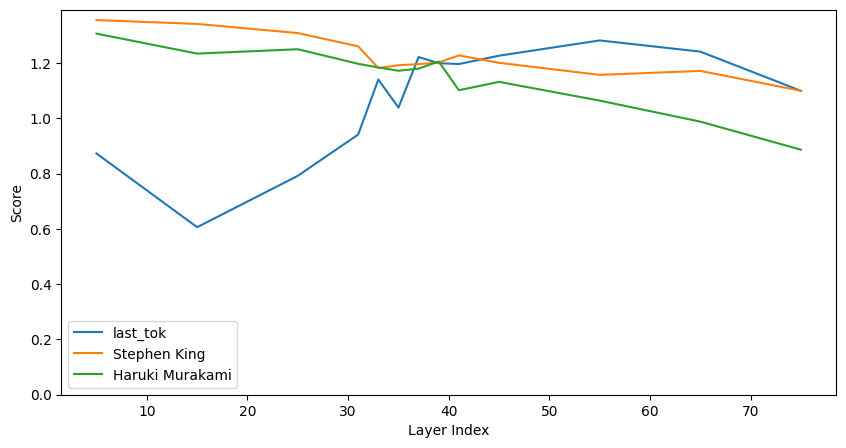

In [58]:
def rank_reward(rank, k=20):
    """
    will return a positive reward if rank is less then 20 (negative log curve)
    will clip the reward to 0 if rank is >= 20
    """
    assert rank >= 1, "rank must be >= 1"
    assert k > 1, "k must be > 1"
    buffer = np.log(k)
    y = (-np.log(rank) + buffer) / buffer
    y = np.clip(y, 0, None)
    return y

from matplotlib import pyplot as plt
import numpy as np

# METRIC = "prob"
METRIC = "logit"

category_scores = {category: [] for category in token_ranges.keys()}

for layer_position, layer_idx in enumerate(layer_indices):
    for key, token_range in token_ranges.items():
        cur_score = None
        for patch_from in token_range:
            ll_pred, ll_track = score_track[key][patch_from][layer_position]
            score = getattr(ll_track[track_toks[0]][1], METRIC)
            denom = sum([getattr(pred, METRIC) for pred in ll_pred]) / len(ll_pred)
            score = score / denom
            # rank = ll_track[track_toks[0]][0]
            # score = rank_reward(rank, k=20)
            cur_score = score if cur_score is None else max(cur_score, score)
        category_scores[key].append(cur_score)


plt.figure(figsize=(10, 5))
for key, scores in category_scores.items():
    # scores = np.array(scores) #/ getattr(ps_pred[0], METRIC)
    scores = np.array(scores)  # / max(scores)  # Normalize scores
    plt.plot(layer_indices, scores, label=key)

plt.legend()
plt.xlabel("Layer Index")
plt.ylabel("Score")
plt.ylim(bottom=0)

The plot tracks how well the model preserves information about the profession when we patch activations from different token positions across layers.

last_tok (blue): Patching from the last token position (" -")
entity1 (orange): Patching from entity1's token positions
entity2 (green): Patching from entity2's token positions

**Early Layers (5-25): Entity information dominates**
- Both entity names start with high scores, indicating they contain strong profession information early on.
- The lastr token starts lower and even drops to 0.6 around layer 15.
- This suggests the model initially encodes profession information in the entity name representations.

**Critical transition around layers 35-40**
- There's a dramatic shift where the last token (blue) begins rising sharply.
- The entity patches begin declining more steeply
- They cross over around layer 37.

**Late Layers: Information moves to output position**
- The last token (blue) maintains high scores, becoming the strongest signal.
- Entity patches continue declining, suggesting the model is "moving" the profession information from entity positions to the output position.
- This is exactly what we would expect for next_token prediction!

**Mechanistic interpretation**
- Early: Profession info is encoded at entity positions
- Middle: Information gets processed and refined
- Late: Information gets transferred to the output position for prediction.

The crossover around layer 37 suggests this is where the model performs the key information routing operation -- taking the profession concept from the entity representations and moving it to where it's needed for output generation.

## Now let's see what happens when we switch Murakami with Beethoven.
i.e. we now expect a connection of "artist" instead of "writer"


In [19]:
new_entity_pair = ["Stephen King", "Beethoven"]

context = """Name of a person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

track_toks = []

for entity in new_entity_pair:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)


Stephen King => " writer"[7061] (p=0.453, logit=24.500)
Beethoven => " composer"[40550] (p=0.922, logit=24.500)


So when we just finish the above context with "Stephen King", the model predicts "writer".
Likewise, for "Beethoven", it predicts "composer".

But now we will see what the model predicts when we patched the hidden representation at the "Stephen King" and "Beethoven" tokens, respectively, from the forward pass with the full BiAssociation prompt.

In [20]:
probing_input = prepare_probing_input(
    mt=mt,
    entities=new_entity_pair,
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -"
)

probing_input

ProbingPrompt(prompt='# Task: Find Common Attributes Between Two People\nYou will be given two people\'s names. Your job is to determine if they share ANY common attribute from the list below.\n\n## Response Format:\n- If you find a match: "Yes - [shared attribute] - [description of what they share]"\n- If no match: "No - [Person 1] and [Person 2] have nothing in common"\n\n## Attributes to Consider:\n1. Same profession → "Yes - [profession] - they are both [profession]"\n2. Same nationality → "Yes - [nationality] - they are both [nationality]"\n3. Same school → "Yes - [school] - they both graduated from [school]"\n\nQ: Person C and Person D\nA: Yes - Doctor - they are both doctors.\n\nQ: Person E and Person F\nA: Yes - Boston University - they both graduated from Boston University.\n\nQ: Person W and Person X\nA: No - Person W and Person X have nothing in common.\n\nQ: Person A and Person B\nA: Yes - German - they are both German.\n\n## Your turn, give your answer in a single line.\n\

In [26]:
from src.functional import generate_with_patch
from src.tokens import TokenizerOutput
import transformers
transformers.logging.set_verbosity_error()

answer = generate_with_patch(
    mt=mt,
    inputs=TokenizerOutput(data=probing_input.tokenized),
    n_gen_per_prompt=1,
    max_new_tokens=8,
    do_sample=False,
    patches=[],
    patch_strategy="replace",
    remove_prefix=True,
    patch_at_all_generations=False
)

answer

[' Artist - they are both artists. \n\n']

In [27]:
resid_layers = mt.layer_names

token_positions = (
    list(range(*probing_input.entity_ranges[0]))
    + list(range(*probing_input.entity_ranges[1]))
    + [-1]
)
token_positions

[245, 246, 248, 249, -1]

In [28]:
import itertools

locations = list(itertools.product(resid_layers, token_positions))
locations += [(mt.lm_head_name, -1)]

locations

[('model.layers.0', 245),
 ('model.layers.0', 246),
 ('model.layers.0', 248),
 ('model.layers.0', 249),
 ('model.layers.0', -1),
 ('model.layers.1', 245),
 ('model.layers.1', 246),
 ('model.layers.1', 248),
 ('model.layers.1', 249),
 ('model.layers.1', -1),
 ('model.layers.2', 245),
 ('model.layers.2', 246),
 ('model.layers.2', 248),
 ('model.layers.2', 249),
 ('model.layers.2', -1),
 ('model.layers.3', 245),
 ('model.layers.3', 246),
 ('model.layers.3', 248),
 ('model.layers.3', 249),
 ('model.layers.3', -1),
 ('model.layers.4', 245),
 ('model.layers.4', 246),
 ('model.layers.4', 248),
 ('model.layers.4', 249),
 ('model.layers.4', -1),
 ('model.layers.5', 245),
 ('model.layers.5', 246),
 ('model.layers.5', 248),
 ('model.layers.5', 249),
 ('model.layers.5', -1),
 ('model.layers.6', 245),
 ('model.layers.6', 246),
 ('model.layers.6', 248),
 ('model.layers.6', 249),
 ('model.layers.6', -1),
 ('model.layers.7', 245),
 ('model.layers.7', 246),
 ('model.layers.7', 248),
 ('model.layers.7',

In [29]:
from src.functional import get_hs

hs = get_hs(
    mt=mt,
    input=TokenizerOutput(data=probing_input.tokenized),
    locations=locations
)

hs

{('model.layers.0',
  245): tensor([ 0.0070, -0.0071,  0.0087,  ...,  0.0055,  0.0120,  0.0009],
        device='cuda:0', dtype=torch.bfloat16),
 ('model.layers.0',
  246): tensor([-0.0015, -0.0009, -0.0083,  ..., -0.0181, -0.0026, -0.0023],
        device='cuda:0', dtype=torch.bfloat16),
 ('model.layers.0',
  248): tensor([-0.0011, -0.0092, -0.0058,  ..., -0.0091, -0.0074,  0.0032],
        device='cuda:0', dtype=torch.bfloat16),
 ('model.layers.0',
  249): tensor([-0.0062, -0.0171, -0.0118,  ..., -0.0200, -0.0132, -0.0183],
        device='cuda:0', dtype=torch.bfloat16),
 ('model.layers.0',
  -1): tensor([ 0.0016, -0.0002,  0.0008,  ..., -0.0011, -0.0028, -0.0084],
        device='cuda:0', dtype=torch.bfloat16),
 ('model.layers.1',
  245): tensor([ 0.0060, -0.0060,  0.0047,  ...,  0.0079,  0.0125,  0.0015],
        device='cuda:1', dtype=torch.bfloat16),
 ('model.layers.1',
  246): tensor([-0.0048, -0.0013, -0.0095,  ..., -0.0142,  0.0020, -0.0039],
        device='cuda:1', dtype=tor

In [30]:
from src.functional import patchscope

token_idx = probing_input.entity_ranges[0][1] - 1
#token_idx = probing_input.entity_ranges[1][1] - 1
layer_idx = 5
patch_layers = [5]

patchscope(
    mt=mt,
    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
    context=context,
    placeholder="placeholder",
    patch_layers=[mt.layer_name_format.format(l) for l in patch_layers],
    k=15
)

[PredictedToken(token=' author', prob=0.478515625, logit=24.0, token_id=3229, metadata=None),
 PredictedToken(token=' writer', prob=0.423828125, logit=23.875, token_id=7061, metadata=None),
 PredictedToken(token=' novelist', prob=0.09423828125, logit=22.375, token_id=81747, metadata=None),
 PredictedToken(token=' Author', prob=0.000560760498046875, logit=17.25, token_id=7030, metadata=None),
 PredictedToken(token=' Writer', prob=0.000339508056640625, logit=16.75, token_id=30504, metadata=None),
 PredictedToken(token=' fiction', prob=0.0002651214599609375, logit=16.5, token_id=17422, metadata=None),
 PredictedToken(token=' (', prob=0.00023365020751953125, logit=16.375, token_id=320, metadata=None),
 PredictedToken(token='writer', prob=0.00020599365234375, logit=16.25, token_id=18688, metadata=None),
 PredictedToken(token=' ', prob=0.00020599365234375, logit=16.25, token_id=220, metadata=None),
 PredictedToken(token=' novel', prob=0.00020599365234375, logit=16.25, token_id=11775, metadat

In [31]:
track_toks = []

for entity in new_entity_pair:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)

track_toks = [p.token_id for p in track_toks]
track_toks = list(set(track_toks))  # remove duplicates
[mt.tokenizer.decode(t) for t in track_toks]

Stephen King => " writer"[7061] (p=0.453, logit=24.500)
Beethoven => " composer"[40550] (p=0.922, logit=24.500)


[' writer', ' composer']

In [32]:
from src.operators.utils import patch
from src.functional import interpret_logits
from src.tokens import find_token_range

context_tok = prepare_input(
    prompts=context,
    tokenizer=mt,
    return_offsets_mapping=True
)

offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1
    )[1]
    - 1
)

layer_indices = [5, 15, 25, 31, 33, 35, 37, 39, 41, 45, 55, 65, 75]
patch_layers = [
    mt.layer_name_format.format(layer_idx) for layer_idx in list(range(5, 16))
]

token_ranges = {
    "last_tok": [-1],
    probing_input.entities[0]: list(range(*probing_input.entity_ranges[0])),
    probing_input.entities[1]: list(range(*probing_input.entity_ranges[1])),
}

inputs = TokenizerOutput(data=probing_input.tokenized)
#print(track_toks[0])
print(f"{[mt.tokenizer.decode(t) for t in track_toks]}")

score_track = {k: {} for k in token_ranges.keys()}

for layer_idx in layer_indices:
    print(f"layer_idx={layer_idx} ({mt.layer_name_format.format(layer_idx)})")
    for key, token_range in token_ranges.items():
        print(
            f'"{key}" {token_range} => "{mt.tokenizer.decode(inputs.input_ids[0][token_range], skip_special_tokens=False)}"'
        )
        for token_idx in token_range:
            ll_pred, ll_track = patchscope(
                mt=mt,
                h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
                context=context,
                placeholder="placeholder",
                context_tokenized=context_tok,
                placeholder_idx=h_idx,
                patch_layers=patch_layers,
                k=15,
                interested_tokens=track_toks,
            )
            ll_fmt = [
                f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                for pred in ll_pred
            ]
            if token_idx not in score_track[key]:
                score_track[key][token_idx] = []
            score_track[key][token_idx].append((ll_pred, ll_track))
            print(
                f'{token_idx=} ["{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}"] => {ll_fmt[:5]}'
            )

        print()

    print("-" * 50)

[' writer', ' composer']
layer_idx=5 (model.layers.5)
"last_tok" [-1] => " -"
token_idx=-1 [" -"] => ['"?\n"[p=0.29, l=14.44]', '"?\n\n"[p=0.13, l=13.62]', '"?"[p=0.07, l=13.06]', '" \n"[p=0.03, l=12.06]', '"??"[p=0.03, l=12.06]']

"Stephen King" [245, 246] => " Stephen King"
token_idx=245 [" Stephen"] => ['"?\n"[p=0.10, l=13.12]', '" philosopher"[p=0.09, l=13.00]', '" actor"[p=0.05, l=12.38]', '"?"[p=0.04, l=12.19]', '" king"[p=0.03, l=11.94]']
token_idx=246 [" King"] => ['" author"[p=0.47, l=24.12]', '" writer"[p=0.42, l=24.00]', '" novelist"[p=0.11, l=22.62]', '" fiction"[p=0.00, l=17.38]', '" Author"[p=0.00, l=17.12]']

"Beethoven" [248, 249] => " Beethoven"
token_idx=248 [" Be"] => ['" singer"[p=0.12, l=11.56]', '" musician"[p=0.08, l=11.19]', '" bee"[p=0.08, l=11.19]', '"?\n"[p=0.03, l=10.06]', '" artist"[p=0.02, l=9.94]']
token_idx=249 ["ethoven"] => ['" composer"[p=0.95, l=23.12]', '" musician"[p=0.04, l=19.88]', '" music"[p=0.00, l=17.88]', '" Composer"[p=0.00, l=17.25]', '" (

2025-06-29 05:03:56 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-06-29 05:03:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-06-29 05:03:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
2025-06-29 05:03:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant=

2025-06-29 05:03:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-06-29 05:03:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-06-29 05:03:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-06-29 05:03:56 matplotlib.font_manager 

(0.0, 1.3970004203408206)

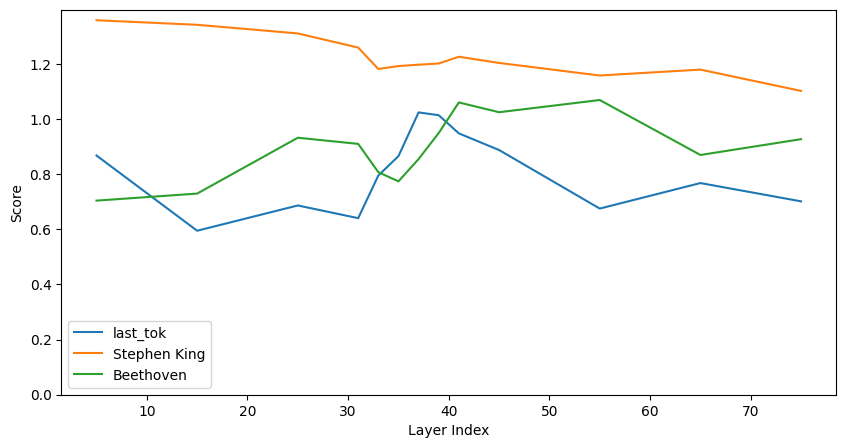

In [35]:
import numpy as np
import matplotlib.pyplot as plt

METRIC = "logit"

category_scores = {category: [] for category in token_ranges.keys()}

for layer_position, layer_idx in enumerate(layer_indices):
    for key, token_range in token_ranges.items():
        cur_score = None
        for patch_from in token_range:
            ll_pred, ll_track = score_track[key][patch_from][layer_position]
            score = getattr(ll_track[track_toks[0]][1], METRIC)
            denom = sum([getattr(pred, METRIC) for pred in ll_pred]) / len(ll_pred)
            score = score / denom
            # rank = ll_track[track_toks[0]][0]
            # score = rank_reward(rank, k=20)
            cur_score = score if cur_score is None else max(cur_score, score)
        category_scores[key].append(cur_score)


plt.figure(figsize=(10, 5))
for key, scores in category_scores.items():
    # scores = np.array(scores) #/ getattr(ps_pred[0], METRIC)
    scores = np.array(scores)  # / max(scores)  # Normalize scores
    plt.plot(layer_indices, scores, label=key)

plt.legend()
plt.xlabel("Layer Index")
plt.ylabel("Score")
plt.ylim(bottom=0)